In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

custom_colors = [
    "#D55E00",
    "#0072B2",
    "#009E73",
    "#F0E442",
    "#CC79A7",
    "#56B4E9",
    "#E69F00",
]
colormap = ListedColormap(custom_colors, name="custom")

In [2]:
#### Problem 1 ####
def sym_three_point(x_val, step_size):

    numerator = np.sin(x_val + step_size) - np.sin(x_val - step_size)
    denominator = 2 * step_size

    return numerator / denominator


def sym_five_point(x_val, step_size):

    numerator = (
        -np.sin(x_val + 2 * step_size)
        + 8 * np.sin(x_val + step_size)
        - 8 * np.sin(x_val - step_size)
        + np.sin(x_val - 2 * step_size)
    )
    denominator = 12 * step_size

    return numerator / denominator


def forward_two_point(x_val, step_size):

    numerator = np.sin(x_val + step_size) - np.sin(x_val)
    denominator = step_size

    return numerator / denominator


def backward_two_point(x_val, step_size):

    numerator = np.sin(x_val) - np.sin(x_val - step_size)
    denominator = step_size

    return numerator / denominator

In [3]:
step_sizes = [
    0.5,
    0.2,
    0.1,
    0.05,
    0.02,
    0.01,
    0.005,
    0.002,
    0.001,
    0.0005,
    0.0002,
    0.0001,
    0.00005,
    0.00002,
    0.00001,
]
centerpoint = 1

sym_three_point_results = [sym_three_point(centerpoint, i) for i in step_sizes]
sym_five_point_results = [sym_five_point(centerpoint, i) for i in step_sizes]
forward_two_point_results = [forward_two_point(centerpoint, i) for i in step_sizes]
backward_two_point_results = [backward_two_point(centerpoint, i) for i in step_sizes]

problem1df = pd.DataFrame(
    {
        "Step Sizes": step_sizes,
        "Symmetric Three Point": sym_three_point_results,
        "Forward Two Point": forward_two_point_results,
        "Backward Two Point": backward_two_point_results,
        "Symmetric Five Point": sym_five_point_results,
    }
)
latex_code = problem1df.to_latex(index=False)

true_value = np.cos(1)

problem1errordf = pd.DataFrame(
    {
        "Step Sizes": step_sizes,
        "Symmetric Three Point": sym_three_point_results - true_value,
        "Forward Two Point": forward_two_point_results - true_value,
        "Backward Two Point": backward_two_point_results - true_value,
        "Symmetric Five Point": sym_five_point_results - true_value,
    }
)

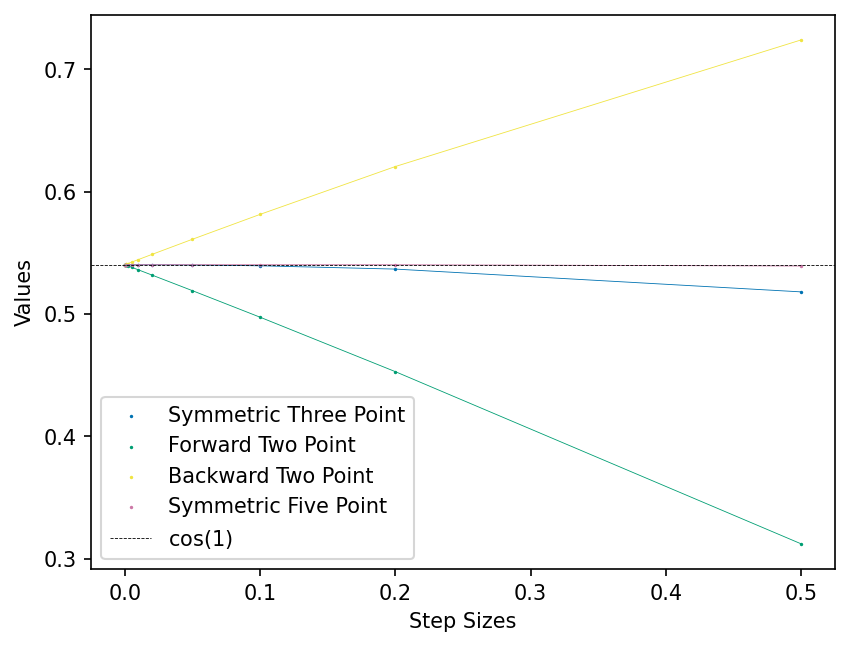

In [4]:
plt.figure(dpi=150)
for n, i in enumerate(problem1df):
    color = colormap(n)
    if "Step Sizes" == i:
        pass
    else:
        plt.scatter(
            problem1df["Step Sizes"],
            problem1df[f"{i}"],
            label=f"{i}",
            s=0.4,
            color=color,
        )
        plt.plot(problem1df["Step Sizes"], problem1df[f"{i}"], lw=0.4, color=color)
plt.axhline(np.cos(1), ls="dashed", c="black", label=r"$\cos(1)$", lw=0.4)
plt.legend()
plt.xlabel("Step Sizes")
plt.ylabel("Values")
# plt.savefig("Num_Methods/problem1.png")
plt.show()

In [5]:
def solve_schrodinger(
    l: int,
    r_min: float,
    r_max: float,
    grid_size: int,
    r0: float,
    a: float,
    N: int,
    Z: int,
    omega: float = 1.0,
    potential_type: str = "woods-saxon",
    pn: str = "p",
):
    """
    Solves the Schrödinger equation for either Woods-Saxon or Harmonic Oscillator potential.

    Args:
        l (int): Angular momentum quantum number.
        r_min (float): Minimum radius in fm.
        r_max (float): Maximum radius in fm.
        grid_size (int): Number of grid points.
        r0 (float): Woods-Saxon parameter r0 in fm.
        a (float): Diffuseness parameter in fm.
        N (int): Neutron count
        Z (int): proton count
        omega (float): Harmonic Oscillator frequency (default: 1.0).
        potential_type (str): "woods-saxon" or "harmonic-oscillator".
        pn (str): "p" for proton potential, "n" for neutron potential.

    Returns:
        tuple: (bound_energies, bound_wavefunctions) - The negative eigenvalues
               and corresponding normalized eigenfunctions.

    Raises:
        ValueError: If `potential_type` or `pn` is invalid.
    """

    def depth(N: int, Z: int, pn: str):
        if pn == "p":
            return -51 - 33 * (N - Z) / (N + Z)
        elif pn == "n":
            return -51 + 33 * (N - Z) / (N + Z)
        else:
            raise ValueError(
                "Invalid particle type. Use 'p' for protons or 'n' for neutrons."
            )

    # Define grid
    step_size = (r_max - r_min) / (grid_size - 1)
    r_vect = np.linspace(r_min, r_max, grid_size)
    omega = 2
    # Define potential
    R = r0 * (N + Z) ** (1 / 3)
    if potential_type == "woods-saxon":
        V_depth = depth(N, Z, pn)
        potential = V_depth / (1 + np.exp((r_vect - R) / a))
    elif potential_type == "harmonic-oscillator":
        potential = 0.5 * omega**2 * r_vect**2 + depth(N, Z, pn)
    else:
        raise ValueError(
            "Invalid potential type. Use 'woods-saxon' or 'harmonic-oscillator'."
        )

    # Define angular momentum term
    ell_term = l * (l + 1) / r_vect**2

    # Define Hamiltonian matrix
    ham_mat = (
        -2 * np.eye(grid_size) + np.eye(grid_size, k=1) + np.eye(grid_size, k=-1)
    ) / (2 * (step_size**2))
    H = -ham_mat + np.diag(ell_term) + np.diag(potential)

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Select negative eigenvalues and normalize wavefunctions
    bound_indices = eigenvalues < 0
    bound_energies = eigenvalues[bound_indices]
    bound_wavefunctions = eigenvectors[:, bound_indices]

    for i in range(bound_wavefunctions.shape[1]):
        norm = np.sqrt(np.sum(bound_wavefunctions[:, i] ** 2) * step_size)
        bound_wavefunctions[:, i] /= norm

    return bound_energies, bound_wavefunctions

In [6]:
l = 0
r_min = 0.0001
r_max = 10
grid_size = 1000
r0 = 1.27
A = 16
a = 0.67
N = 8
Z = 8
r_vect = np.linspace(r_min, r_max, grid_size)

bound_energies_ws, bound_wavefunctions_ws = solve_schrodinger(
    l=l,
    r_min=r_min,
    r_max=r_max,
    grid_size=grid_size,
    r0=r0,
    a=a,
    N=N,
    Z=Z,
    potential_type="woods-saxon",
    pn="p",
)

bound_energies_ho, bound_wavefunctions_ho = solve_schrodinger(
    l=l,
    r_min=r_min,
    r_max=r_max,
    grid_size=grid_size,
    r0=r0,
    a=a,
    N=N,
    Z=Z,
    potential_type="harmonic-oscillator",
    pn="p",
)

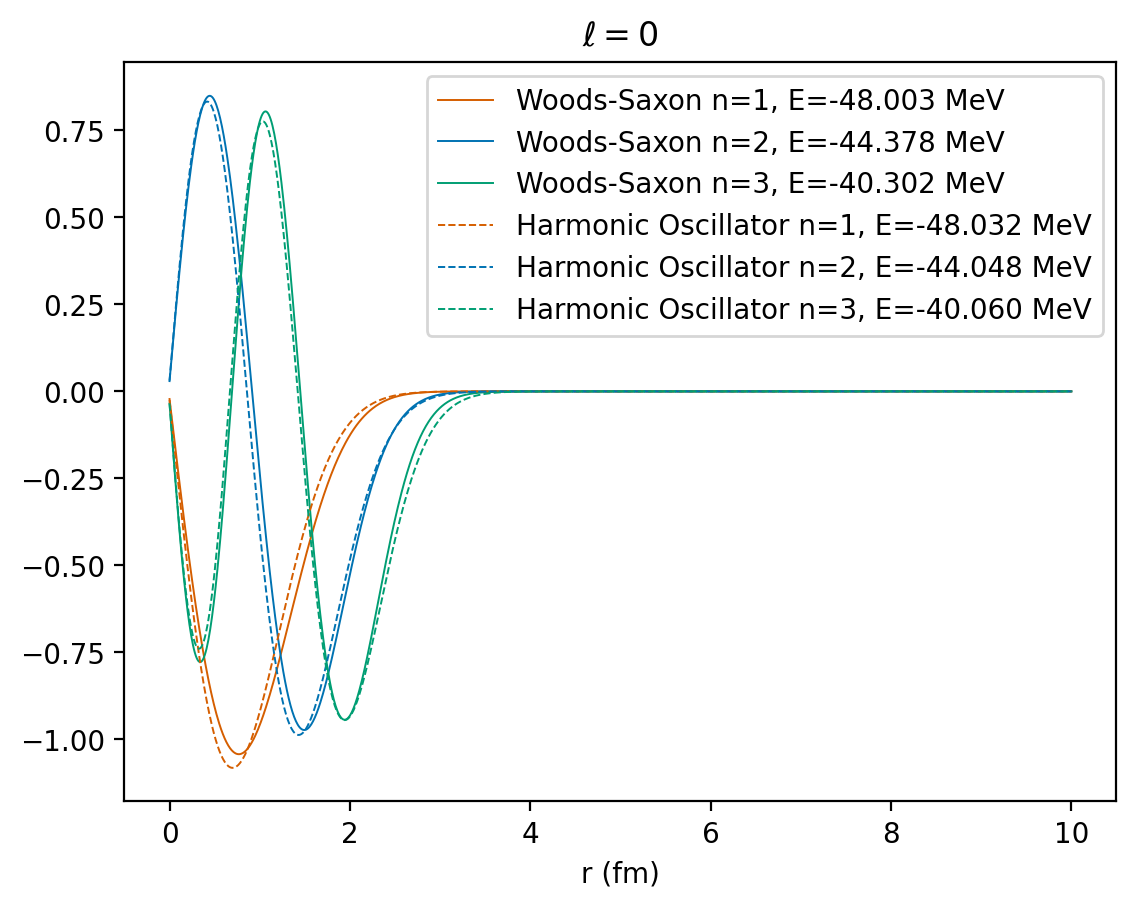

In [7]:
# Plot Woods-Saxon and Harmonic Oscillator wavefunctions
plt.figure(dpi=200)
plot_num = 3
for i, energy in enumerate(bound_energies_ws[:plot_num]):  # Woods-Saxon
    color = colormap(i)  # Get a consistent color for this index
    plt.plot(
        r_vect,
        bound_wavefunctions_ws[:, i],
        label=f"Woods-Saxon n={i+1}, E={energy:.3f} MeV",
        lw=0.7,
        color=color,
    )

for j, energy_HO in enumerate(bound_energies_ho[:plot_num]):  # Harmonic Oscillator
    color = colormap(j)  # Use the same color as for Woods-Saxon
    plt.plot(
        r_vect,
        bound_wavefunctions_ho[:, j],
        label=f"Harmonic Oscillator n={j+1}, E={energy_HO:.3f} MeV",
        lw=0.7,
        ls="dashed",
        color=color,
    )

plt.xlabel("r (fm)")
plt.title(rf"$\ell = {l}$")
plt.legend()
plt.show()